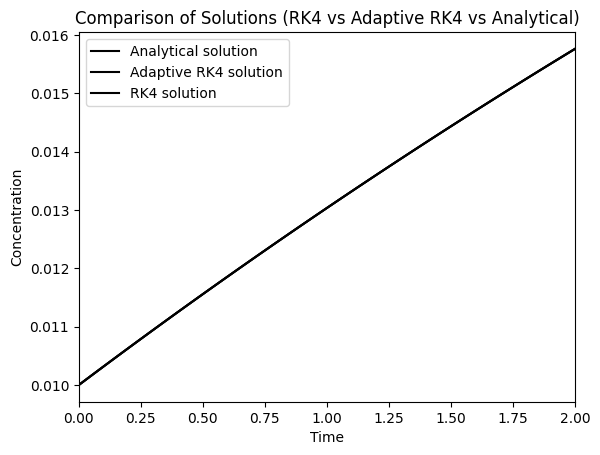

Maximum Error (Adaptive RK4): 3.434752482434078e-16
Maximum Error (RK4): 2.1822821327788233e-15


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# SIMULATE 1: an ideal carbon dioxide concentration measurement.
def model(t, C, n, p, Ca, Q, CE, V):
    dCdt = (1/V) * ((n * p * Ca) + (Q * CE) - (Q * C))
    return dCdt

def analytical_solution(t, n, p, Ca, Q, CE, V):
    return CE + ((n * p * Ca) / Q) * (1 - np.exp(-(Q * t)/V))

def runge_kutta_adaptive(model, t, w, h, n, p, Ca, Q, CE, V):
    k1 = h * model(t, w, n, p, Ca, Q, CE, V)
    k2 = h * model(t + 1/4 * h, w + 1/4 * k1, n, p, Ca, Q, CE, V)
    k3 = h * model(t + 3/8 * h, w + 3/32 * k1 + 9/32 * k2, n, p, Ca, Q, CE, V)
    k4 = h * model(t + 12/13 * h, w + 1932/2197 * k1 - 7200/2197 * k2 + 7296/2197 * k3, n, p, Ca, Q, CE, V)
    k5 = h * model(t + h, w + 439/216 * k1 - 8 * k2 + 3680/513 * k3 - 845/4104 * k4, n, p, Ca, Q, CE, V)
    k6 = h * model(t + 1/2 * h, w - 8/27 * k1 + 2/27 * k2 - 3544/2565 * k3 + 1859/4104 * k4 - 11/40 * k5, n, p, Ca, Q, CE, V)

    w_new = w + 25/216 * k1 + 1408/2565 * k3 + 2197/4104 * k4 - 1/5 * k5

    return w_new

# Runge-Kutta (RK4) solver
def rk4_solver(model, C0, t, n, p, Ca, Q, CE, V):
    dt = t[1] - t[0]
    C_rk4 = np.zeros_like(t)
    C_rk4[0] = C0

    for i in range(1, len(t)):
        k1 = model(t[i-1], C_rk4[i-1], n, p, Ca, Q, CE, V)
        k2 = model(t[i-1] + 0.5*dt, C_rk4[i-1] + 0.5*dt*k1, n, p, Ca, Q, CE, V)
        k3 = model(t[i-1] + 0.5*dt, C_rk4[i-1] + 0.5*dt*k2, n, p, Ca, Q, CE, V)
        k4 = model(t[i-1] + dt, C_rk4[i-1] + dt*k3, n, p, Ca, Q, CE, V)

        C_rk4[i] = C_rk4[i-1] + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)

    return C_rk4

def adaptive_rk4_solver(model, C0, t, n, p, Ca, Q, CE, V, tol=1e-3):
    C_adaptive_rk4 = np.zeros_like(t)
    C_adaptive_rk4[0] = C0

    i = 0
    hmax = t[1] - t[0]
    hmin = 0.01
    flag = 1

    while flag == 1 and i < len(t) - 1:  # Adjust the loop condition here
        dt = t[i+1] - t[i]
        k1 = model(t[i], C_adaptive_rk4[i], n, p, Ca, Q, CE, V)
        k2 = model(t[i] + 0.5 * dt, C_adaptive_rk4[i] + 0.5 * dt * k1, n, p, Ca, Q, CE, V)
        k3 = model(t[i] + 0.5 * dt, C_adaptive_rk4[i] + 0.5 * dt * k2, n, p, Ca, Q, CE, V)
        k4 = model(t[i] + dt, C_adaptive_rk4[i] + dt * k3, n, p, Ca, Q, CE, V)

        # Estimate error
        error = np.abs((dt/6.0) * (k1 + 2*k2 + 2*k3 + k4))

        # Adjust the time step based on the error and tolerance
        delta = 0.84 * (tol / error)**0.25

        if delta <= 0.1:
            dt = 0.1 * dt
        elif delta >= 4:
            dt = 4 * dt
        else:
            dt = delta * dt

        if dt > hmax:
            dt = hmax

        if t[i] + dt > t[-1]:
            dt = t[-1] - t[i]
            flag = 0

        C_adaptive_rk4[i+1] = runge_kutta_adaptive(model, t[i], C_adaptive_rk4[i], dt, n, p, Ca, Q, CE, V)

        i += 1

    return C_adaptive_rk4[:i+1]  # Trim the result array to the actual size


# Define parameters
n = 50
p = 0.12
Ca = 0.04
Q = 8
CE = 0.01
V = 75

# Define initial conditions
C0 = 0.01  # Initial concentration

# Define time points
t = np.arange(0, 2.025, 0.025)

# Solve the differential equation using RK4 method
C_rk4 = rk4_solver(model, C0, t, n, p, Ca, Q, CE, V)

# Solve the differential equation using Adaptive RK4 method
C_adaptive_rk4 = adaptive_rk4_solver(model, C0, t, n, p, Ca, Q, CE, V)

# Analytical solution
C_analytical = analytical_solution(t, n, p, Ca, Q, CE, V)

# Plot the solutions
plt.plot(t, C_analytical, label='Analytical solution', marker = '', linestyle='-', color = "black")
plt.plot(t, C_adaptive_rk4, label='Adaptive RK4 solution', marker = '', linestyle='-', color = "black")
plt.plot(t, C_rk4, label='RK4 solution', marker = '', linestyle='-', color = "black")
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Comparison of Solutions (RK4 vs Adaptive RK4 vs Analytical)')
plt.xlim(0, 2)
plt.legend()
plt.show()


# Calculate and print the maximum errors
max_error_adaptive_rk4 = np.max(np.abs(C_adaptive_rk4 - C_analytical))
max_error_rk4 = np.max(np.abs(C_rk4 - C_analytical))
print("Maximum Error (Adaptive RK4):", max_error_adaptive_rk4)
print("Maximum Error (RK4):", max_error_rk4)

Maximum Error RK4 at ∆t = 0.100: 5.627651122885879e-13
Maximum Error ARK4 at ∆t = 0.100: 8.774578286185886e-14
Maximum Error RK4 at ∆t = 0.050: 5.627651122885879e-13
Maximum Error ARK4 at ∆t = 0.050: 8.774578286185886e-14
Maximum Error RK4 at ∆t = 0.025: 9.084618474153316e-12
Maximum Error ARK4 at ∆t = 0.025: 0.00018905726527284478


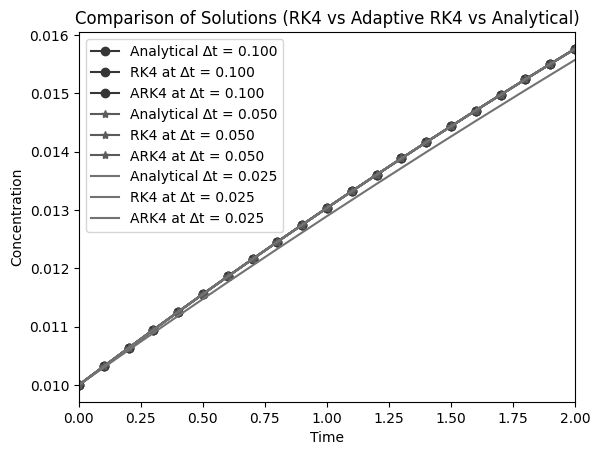

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# SIMULATE 1: an ideal carbon dioxide concentration measurement.
def model(t, C, n, p, Ca, Q, CE, V):
    dCdt = (1/V) * ((n * p * Ca) + (Q * CE) - (Q * C))
    return dCdt

def analytical_solution(t, n, p, Ca, Q, CE, V):
    return CE + ((n * p * Ca) / Q) * (1 - np.exp(-(Q * t)/V))

def runge_kutta_adaptive(model, t, w, h, n, p, Ca, Q, CE, V):
    k1 = h * model(t, w, n, p, Ca, Q, CE, V)
    k2 = h * model(t + 1/4 * h, w + 1/4 * k1, n, p, Ca, Q, CE, V)
    k3 = h * model(t + 3/8 * h, w + 3/32 * k1 + 9/32 * k2, n, p, Ca, Q, CE, V)
    k4 = h * model(t + 12/13 * h, w + 1932/2197 * k1 - 7200/2197 * k2 + 7296/2197 * k3, n, p, Ca, Q, CE, V)
    k5 = h * model(t + h, w + 439/216 * k1 - 8 * k2 + 3680/513 * k3 - 845/4104 * k4, n, p, Ca, Q, CE, V)
    k6 = h * model(t + 1/2 * h, w - 8/27 * k1 + 2/27 * k2 - 3544/2565 * k3 + 1859/4104 * k4 - 11/40 * k5, n, p, Ca, Q, CE, V)

    w_new = w + 25/216 * k1 + 1408/2565 * k3 + 2197/4104 * k4 - 1/5 * k5

    return w_new

# Runge-Kutta (RK4) solver
def rk4_solver(model, C0, t, n, p, Ca, Q, CE, V):
    dt = t[1] - t[0]
    C_rk4 = np.zeros_like(t)
    C_rk4[0] = C0

    for i in range(1, len(t)):
        k1 = model(t[i-1], C_rk4[i-1], n, p, Ca, Q, CE, V)
        k2 = model(t[i-1] + 0.5*dt, C_rk4[i-1] + 0.5*dt*k1, n, p, Ca, Q, CE, V)
        k3 = model(t[i-1] + 0.5*dt, C_rk4[i-1] + 0.5*dt*k2, n, p, Ca, Q, CE, V)
        k4 = model(t[i-1] + dt, C_rk4[i-1] + dt*k3, n, p, Ca, Q, CE, V)

        C_rk4[i] = C_rk4[i-1] + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)

    return C_rk4

def adaptive_rk4_solver(model, C0, t, n, p, Ca, Q, CE, V, tol=1e-3):
    C_adaptive_rk4 = np.zeros_like(t)
    C_adaptive_rk4[0] = C0

    i = 0
    hmax = t[1] - t[0]
    hmin = 0.01
    flag = 1

    while flag == 1 and i < len(t) - 1:  # Adjust the loop condition here
        dt = t[i+1] - t[i]
        k1 = model(t[i], C_adaptive_rk4[i], n, p, Ca, Q, CE, V)
        k2 = model(t[i] + 0.5 * dt, C_adaptive_rk4[i] + 0.5 * dt * k1, n, p, Ca, Q, CE, V)
        k3 = model(t[i] + 0.5 * dt, C_adaptive_rk4[i] + 0.5 * dt * k2, n, p, Ca, Q, CE, V)
        k4 = model(t[i] + dt, C_adaptive_rk4[i] + dt * k3, n, p, Ca, Q, CE, V)

        # Estimate error
        error = np.abs((dt/6.0) * (k1 + 2*k2 + 2*k3 + k4))

        # Adjust the time step based on the error and tolerance
        delta = 0.84 * (tol / error)**0.25

        if delta <= 0.1:
            dt = 0.1 * dt
        elif delta >= 4:
            dt = 4 * dt
        else:
            dt = delta * dt

        if dt > hmax:
            dt = hmax

        if t[i] + dt > t[-1]:
            dt = t[-1] - t[i]
            flag = 0

        C_adaptive_rk4[i+1] = runge_kutta_adaptive(model, t[i], C_adaptive_rk4[i], dt, n, p, Ca, Q, CE, V)

        i += 1

    return C_adaptive_rk4[:i+1]  # Trim the result array to the actual size


# Define parameters
n = 50
p = 0.12
Ca = 0.04
Q = 8
CE = 0.01
V = 75
t = [0.100, 0.050, 0.025]
colors = ['#363636', '#5c5b5b', '#737272']
labels = ["RK4 at ∆t = 0.100", "RK4 at ∆t = 0.050", "RK4 at ∆t = 0.025"]
labels_2 = ["ARK4 at ∆t = 0.100", "ARK4 at ∆t = 0.050", "ARK4 at ∆t = 0.025"]
labels_3 = ["Analytical ∆t = 0.100", "Analytical ∆t = 0.050", "Analytical ∆t = 0.025"]
markers = ['o', '*', '']



for i in range(len(t)):

    # Define initial conditions
    C0 = 0.01  # Initial concentration

    # Define time points
    t = np.arange(0, 2.025, t[i])

    # Analytical solution
    C_analytical = analytical_solution(t, n, p, Ca, Q, CE, V)
    plt.plot(t, C_analytical, label=labels_3[i], marker = markers[i], linestyle='-', color = colors[i])


    # Solve the differential equation using RK4 method
    C_rk4 = rk4_solver(model, C0, t, n, p, Ca, Q, CE, V)
    plt.plot(t, C_rk4, label=labels[i], marker = markers[i], linestyle='-', color = colors[i])
    max_error_rk4 = np.max(np.abs(C_rk4 - C_analytical))
    print(f"Maximum Error {labels[i]}:", max_error_rk4)

    # Solve the differential equation using Adaptive RK4 method
    C_adaptive_rk4 = adaptive_rk4_solver(model, C0, t, n, p, Ca, Q, CE, V)
    plt.plot(t, C_adaptive_rk4, label=labels_2[i], marker = markers[i], linestyle='-', color = colors[i])
    # Calculate and print the maximum errors
    max_error_adaptive_rk4 = np.max(np.abs(C_adaptive_rk4 - C_analytical))
    print(f"Maximum Error {labels_2[i]}:", max_error_adaptive_rk4)


# Plot the solutions
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Comparison of Solutions (RK4 vs Adaptive RK4 vs Analytical)')
plt.xlim(0, 2)
plt.legend()
plt.show()


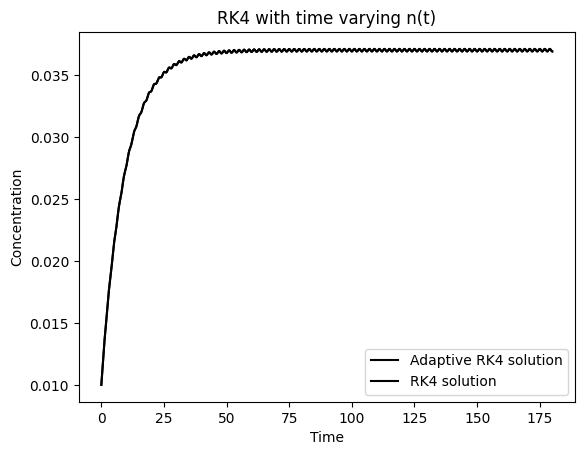

Maximum Error (Adaptive RK4): 0.00299654553856199
Maximum Error (RK4): 0.0029965455386991094


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# SIMULATE 1: an ideal carbon dioxide concentration measurement.
def n(t):
    return 45 + 5*np.sin(np.pi*t)


def model(t, C, p, Ca, Q, CE, V):
    dCdt = (1/V) * ((n(t) * p * Ca) + (Q * CE) - (Q * C))
    return dCdt

def analytical_solution(t, p, Ca, Q, CE, V):
    return CE + ((n(t) * p * Ca) / Q) * (1 - np.exp(-(Q * t)/V))


def runge_kutta_adaptive(model, t, w, h, p, Ca, Q, CE, V):
    k1 = h * model(t, w, p, Ca, Q, CE, V)
    k2 = h * model(t + 1/4 * h, w + 1/4 * k1, p, Ca, Q, CE, V)
    k3 = h * model(t + 3/8 * h, w + 3/32 * k1 + 9/32 * k2, p, Ca, Q, CE, V)
    k4 = h * model(t + 12/13 * h, w + 1932/2197 * k1 - 7200/2197 * k2 + 7296/2197 * k3, p, Ca, Q, CE, V)
    k5 = h * model(t + h, w + 439/216 * k1 - 8 * k2 + 3680/513 * k3 - 845/4104 * k4, p, Ca, Q, CE, V)
    k6 = h * model(t + 1/2 * h, w - 8/27 * k1 + 2/27 * k2 - 3544/2565 * k3 + 1859/4104 * k4 - 11/40 * k5, p, Ca, Q, CE, V)

    w_new = w + 25/216 * k1 + 1408/2565 * k3 + 2197/4104 * k4 - 1/5 * k5

    return w_new

# Runge-Kutta (RK4) solver
def rk4_solver(model, C0, t, p, Ca, Q, CE, V):
    dt = t[1] - t[0]
    C_rk4 = np.zeros_like(t)
    C_rk4[0] = C0

    for i in range(1, len(t)):
        k1 = model(t[i-1], C_rk4[i-1], p, Ca, Q, CE, V)
        k2 = model(t[i-1] + 0.5*dt, C_rk4[i-1] + 0.5*dt*k1, p, Ca, Q, CE, V)
        k3 = model(t[i-1] + 0.5*dt, C_rk4[i-1] + 0.5*dt*k2, p, Ca, Q, CE, V)
        k4 = model(t[i-1] + dt, C_rk4[i-1] + dt*k3, p, Ca, Q, CE, V)

        C_rk4[i] = C_rk4[i-1] + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)

    return C_rk4

def adaptive_rk4_solver(model, C0, t, p, Ca, Q, CE, V, tol=1e-3):
    C_adaptive_rk4 = np.zeros_like(t)
    C_adaptive_rk4[0] = C0

    i = 0
    hmax = t[1] - t[0]
    hmin = 0.01
    flag = 1

    while flag == 1 and i < len(t) - 1:  # Adjust the loop condition here
        dt = t[i+1] - t[i]
        k1 = model(t[i], C_adaptive_rk4[i], p, Ca, Q, CE, V)
        k2 = model(t[i] + 0.5 * dt, C_adaptive_rk4[i] + 0.5 * dt * k1, p, Ca, Q, CE, V)
        k3 = model(t[i] + 0.5 * dt, C_adaptive_rk4[i] + 0.5 * dt * k2, p, Ca, Q, CE, V)
        k4 = model(t[i] + dt, C_adaptive_rk4[i] + dt * k3, p, Ca, Q, CE, V)

        # Estimate error
        error = np.abs((dt/6.0) * (k1 + 2*k2 + 2*k3 + k4))

        # Adjust the time step based on the error and tolerance
        delta = 0.84 * (tol / error)**0.25

        if delta <= 0.1:
            dt = 0.1 * dt
        elif delta >= 4:
            dt = 4 * dt
        else:
            dt = delta * dt

        if dt > hmax:
            dt = hmax

        if t[i] + dt > t[-1]:
            dt = t[-1] - t[i]
            flag = 0

        C_adaptive_rk4[i+1] = runge_kutta_adaptive(model, t[i], C_adaptive_rk4[i], dt, p, Ca, Q, CE, V)

        i += 1

    return C_adaptive_rk4[:i+1]  # Trim the result array to the actual size


# Define parameters
p = 0.12
Ca = 0.04
Q = 8
CE = 0.01
V = 75

# Define initial conditions
C0 = 0.01  # Initial concentration

# Define time points
t = np.arange(0, 180, 0.025)

# Solve the differential equation using RK4 method
C_rk4 = rk4_solver(model, C0, t, p, Ca, Q, CE, V)

# Solve the differential equation using Adaptive RK4 method
C_adaptive_rk4 = adaptive_rk4_solver(model, C0, t, p, Ca, Q, CE, V)

# Analytical solution
C_analytical = analytical_solution(t, p, Ca, Q, CE, V)


# Plot the solutions
plt.plot(t, C_adaptive_rk4, label='Adaptive RK4 solution', marker = '', linestyle='-', color = "black")
plt.plot(t, C_rk4, label='RK4 solution', marker = '', linestyle='-', color = "black")
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('RK4 with time varying n(t)')
plt.legend()
plt.show()


# Calculate and print the maximum errors
max_error_adaptive_rk4 = np.max(np.abs(C_adaptive_rk4 - C_analytical))
max_error_rk4 = np.max(np.abs(C_rk4 - C_analytical))
print("Maximum Error (Adaptive RK4):", max_error_adaptive_rk4)
print("Maximum Error (RK4):", max_error_rk4)

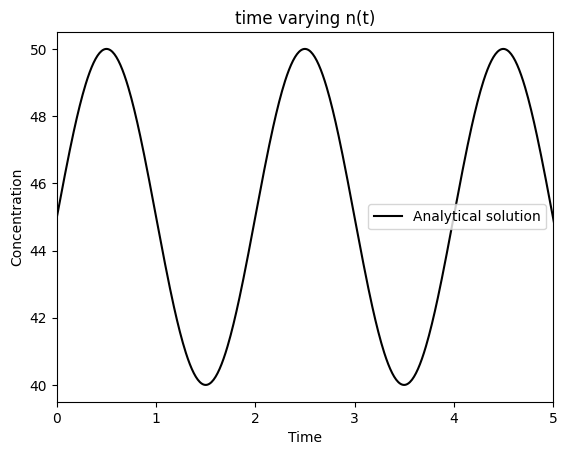

In [3]:

def n(t):
    return 45 + 5*np.sin(np.pi*t)

# Define time points
t = np.arange(0, 180, 0.010)
y_v = [45]

for i in range(1, len(t)):
    y = n(t[i])
    y_v.append(y)

plt.plot(t, y_v, label='Analytical solution', marker = '', linestyle='-', color = "black")
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('time varying n(t)')
plt.xlim(0, 5)
plt.legend()
plt.show()

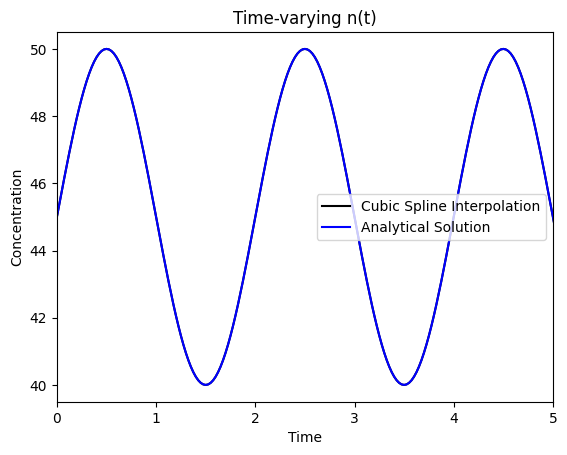

Mean absolute error (Cubic Spline): 1.2285086528309978e-13


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Define analytical solution function
def n(t):
    return 45 + 5 * np.sin(np.pi * t)

# Define time points
t = np.arange(0, 180, 0.025)

# Generate data points using the analytical solution
y_v = [n(t_i) for t_i in t]

# Perform cubic spline interpolation
cs = CubicSpline(t, y_v)

# Create finer time points for smooth plotting
t_interp = np.linspace(0, 179.975, 7200)  # Adjust the range for a smoother curve
y_interp = cs(t_interp)

# Plotting the analytical solution and cubic spline interpolation
plt.plot(t_interp, y_interp, label='Cubic Spline Interpolation', marker = '', linestyle='-', color="black")
plt.plot(t, y_v, label='Analytical Solution', marker='', linestyle='-', color="blue")

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Time-varying n(t)')
plt.xlim(0, 5)
plt.legend()
plt.show()

# Compare cubic spline values with analytical solution
spline_error = np.abs(y_interp - y_v)
mean_error_spline = np.mean(spline_error)
print("Mean absolute error (Cubic Spline):", mean_error_spline)


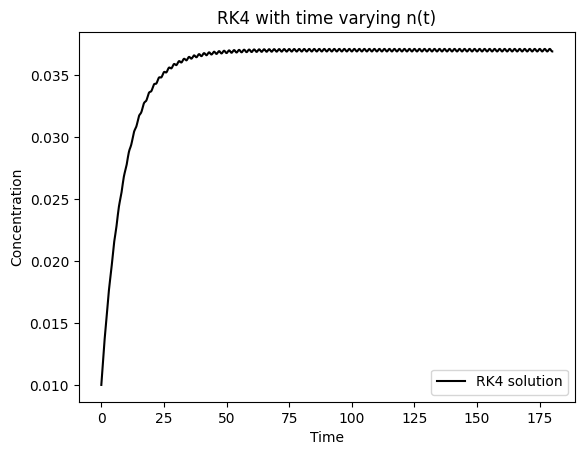

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# SIMULATE 1: an ideal carbon dioxide concentration measurement.
# Generate data points using the analytical solution
t_analytical = np.arange(0, 180, 0.010)
n_t_analytical = 45 + 5 * np.sin(np.pi * t_analytical)

# Perform cubic spline interpolation on the analytical solution
cs = CubicSpline(t_analytical, n_t_analytical)

def model(t, C, p, Ca, Q, CE, V):
    dCdt = (1/V) * ((cs(t) * p * Ca) + (Q * CE) - (Q * C))
    return dCdt



def runge_kutta_adaptive(model, t, w, h, p, Ca, Q, CE, V):
    k1 = h * model(t, w, p, Ca, Q, CE, V)
    k2 = h * model(t + 1/4 * h, w + 1/4 * k1, p, Ca, Q, CE, V)
    k3 = h * model(t + 3/8 * h, w + 3/32 * k1 + 9/32 * k2, p, Ca, Q, CE, V)
    k4 = h * model(t + 12/13 * h, w + 1932/2197 * k1 - 7200/2197 * k2 + 7296/2197 * k3, p, Ca, Q, CE, V)
    k5 = h * model(t + h, w + 439/216 * k1 - 8 * k2 + 3680/513 * k3 - 845/4104 * k4, p, Ca, Q, CE, V)
    k6 = h * model(t + 1/2 * h, w - 8/27 * k1 + 2/27 * k2 - 3544/2565 * k3 + 1859/4104 * k4 - 11/40 * k5, p, Ca, Q, CE, V)

    w_new = w + 25/216 * k1 + 1408/2565 * k3 + 2197/4104 * k4 - 1/5 * k5

    return w_new

# Runge-Kutta (RK4) solver
def rk4_solver(model, C0, t, p, Ca, Q, CE, V):
    dt = t[1] - t[0]
    C_rk4 = np.zeros_like(t)
    C_rk4[0] = C0

    for i in range(1, len(t)):
        k1 = model(t[i-1], C_rk4[i-1], p, Ca, Q, CE, V)
        k2 = model(t[i-1] + 0.5*dt, C_rk4[i-1] + 0.5*dt*k1, p, Ca, Q, CE, V)
        k3 = model(t[i-1] + 0.5*dt, C_rk4[i-1] + 0.5*dt*k2, p, Ca, Q, CE, V)
        k4 = model(t[i-1] + dt, C_rk4[i-1] + dt*k3, p, Ca, Q, CE, V)

        C_rk4[i] = C_rk4[i-1] + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)

    return C_rk4

def adaptive_rk4_solver(model, C0, t, p, Ca, Q, CE, V, tol=1e-3):
    C_adaptive_rk4 = np.zeros_like(t)
    C_adaptive_rk4[0] = C0

    i = 0
    hmax = t[1] - t[0]
    hmin = 0.01
    flag = 1

    while flag == 1 and i < len(t) - 1:  # Adjust the loop condition here
        dt = t[i+1] - t[i]
        k1 = model(t[i], C_adaptive_rk4[i], p, Ca, Q, CE, V)
        k2 = model(t[i] + 0.5 * dt, C_adaptive_rk4[i] + 0.5 * dt * k1, p, Ca, Q, CE, V)
        k3 = model(t[i] + 0.5 * dt, C_adaptive_rk4[i] + 0.5 * dt * k2, p, Ca, Q, CE, V)
        k4 = model(t[i] + dt, C_adaptive_rk4[i] + dt * k3, p, Ca, Q, CE, V)

        # Estimate error
        error = np.abs((dt/6.0) * (k1 + 2*k2 + 2*k3 + k4))

        # Adjust the time step based on the error and tolerance
        delta = 0.84 * (tol / error)**0.25

        if delta <= 0.1:
            dt = 0.1 * dt
        elif delta >= 4:
            dt = 4 * dt
        else:
            dt = delta * dt

        if dt > hmax:
            dt = hmax

        if t[i] + dt > t[-1]:
            dt = t[-1] - t[i]
            flag = 0

        C_adaptive_rk4[i+1] = runge_kutta_adaptive(model, t[i], C_adaptive_rk4[i], dt, p, Ca, Q, CE, V)

        i += 1

    return C_adaptive_rk4[:i+1]  # Trim the result array to the actual size


# Define parameters
p = 0.12
Ca = 0.04
Q = 8
CE = 0.01
V = 75

# Define initial conditions
C0 = 0.01  # Initial concentration

# Define time points
t = np.arange(0, 180, 0.010)


# Solve the differential equation using Adaptive RK4 method
C_adaptive_rk4 = adaptive_rk4_solver(model, C0, t, p, Ca, Q, CE, V)



# Plot the solutions
plt.plot(t, C_adaptive_rk4, label='RK4 solution', marker = '', linestyle='-', color = "black")
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('RK4 with time varying n(t)')
plt.legend()
plt.show()



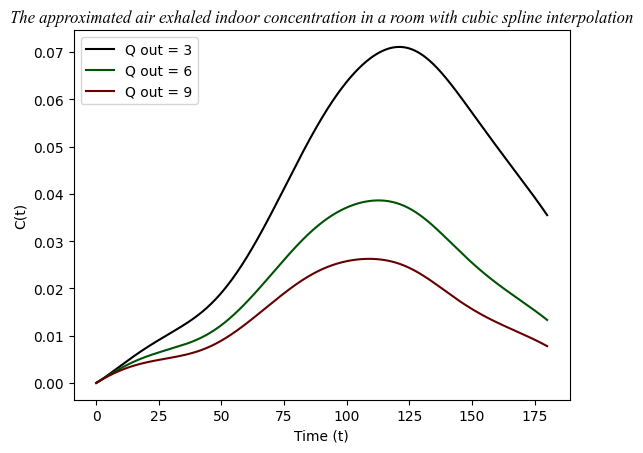

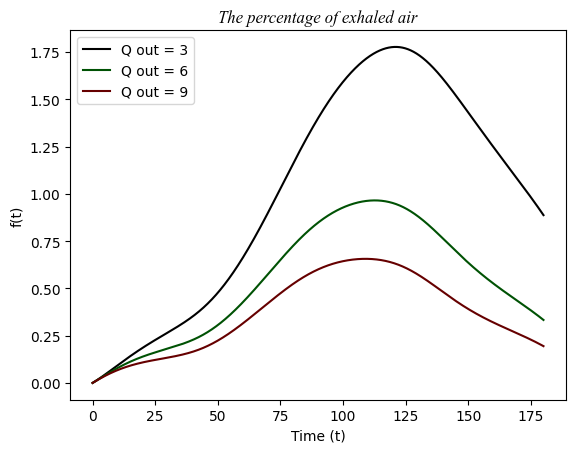

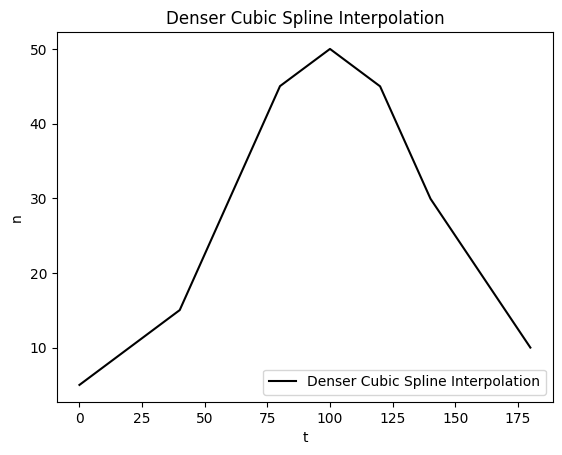

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# SIMULATION 5: The risk of normal peoples who staying in a room with infectors.
t_real = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180]
n_t_real = [5, 10, 15, 30, 45, 50, 45, 30, 20, 10]

# Perform cubic spline interpolation based on real data
cs = CubicSpline(t_real, n_t_real)
cs_pts = cs.c


def model(t, C, p, Ca, Q, CE, V):
    dCdt = (1/V) * ((cs(t) * p * Ca) - (Q * C))
    return dCdt

# Define a function to calculate f(t) = C(t) / Ca
def calculate_f(C, Ca):
    return C / Ca



def runge_kutta_adaptive(model, t, w, h, p, Ca, Q, CE, V):
    k1 = h * model(t, w, p, Ca, Q, CE, V)
    k2 = h * model(t + 1/4 * h, w + 1/4 * k1, p, Ca, Q, CE, V)
    k3 = h * model(t + 3/8 * h, w + 3/32 * k1 + 9/32 * k2, p, Ca, Q, CE, V)
    k4 = h * model(t + 12/13 * h, w + 1932/2197 * k1 - 7200/2197 * k2 + 7296/2197 * k3, p, Ca, Q, CE, V)
    k5 = h * model(t + h, w + 439/216 * k1 - 8 * k2 + 3680/513 * k3 - 845/4104 * k4, p, Ca, Q, CE, V)
    k6 = h * model(t + 1/2 * h, w - 8/27 * k1 + 2/27 * k2 - 3544/2565 * k3 + 1859/4104 * k4 - 11/40 * k5, p, Ca, Q, CE, V)

    w_new = w + 25/216 * k1 + 1408/2565 * k3 + 2197/4104 * k4 - 1/5 * k5

    return w_new


def adaptive_rk4_solver(model, C0, t, p, Ca, Q, CE, V, tol=1e-3):
    C_adaptive_rk4 = np.zeros_like(t)
    C_adaptive_rk4[0] = C0

    i = 0
    hmax = t[1] - t[0]
    hmin = 0.01
    flag = 1

    while flag == 1 and i < len(t) - 1:  # Adjust the loop condition here
        dt = t[i+1] - t[i]
        k1 = model(t[i], C_adaptive_rk4[i], p, Ca, Q, CE, V)
        k2 = model(t[i] + 0.5 * dt, C_adaptive_rk4[i] + 0.5 * dt * k1, p, Ca, Q, CE, V)
        k3 = model(t[i] + 0.5 * dt, C_adaptive_rk4[i] + 0.5 * dt * k2, p, Ca, Q, CE, V)
        k4 = model(t[i] + dt, C_adaptive_rk4[i] + dt * k3, p, Ca, Q, CE, V)

        # Estimate error
        error = np.abs((dt/6.0) * (k1 + 2*k2 + 2*k3 + k4))

        # Adjust the time step based on the error and tolerance
        delta = 0.84 * (tol / error)**0.25

        if delta <= 0.1:
            dt = 0.1 * dt
        elif delta >= 4:
            dt = 4 * dt
        else:
            dt = delta * dt

        if dt > hmax:
            dt = hmax

        if t[i] + dt > t[-1]:
            dt = t[-1] - t[i]
            flag = 0

        C_adaptive_rk4[i+1] = runge_kutta_adaptive(model, t[i], C_adaptive_rk4[i], dt, p, Ca, Q, CE, V)

        i += 1

    return C_adaptive_rk4[:i+1]  # Trim the result array to the actual size


# Define parameters
p = 0.12
Ca = 0.04
Q = [3, 6, 9]
CE = 0.01
V = 75
labels = ["Q out = 3", "Q out = 6", "Q out = 9"]
colors = ['black', '#005204', '#660000']

# Define initial conditions
C0 = 0  # Initial concentration

# Define time points
t = np.arange(0, 180, 0.010)
f_adaptive_rk4 = []

for i in range(len(Q)):
    # Solve the differential equation using Adaptive RK4 method
    C_adaptive_rk4 = adaptive_rk4_solver(model, C0, t, p, Ca, Q[i], CE, V)

    # Calculate f_adaptive_rk4 using the computed C_adaptive_rk4 and Ca
    f_adaptive= calculate_f(C_adaptive_rk4, Ca)
    f_adaptive_rk4.append(f_adaptive)


    # Generate more data points for a denser spline
    t_dense = np.linspace(0, 180, 7200)  # Create a denser set of time points
    n_dense = np.interp(t_dense, t_real, n_t_real)  # Interpolate values at denser time points

    # Perform cubic spline interpolation on the denser data
    cs_dense = CubicSpline(t_dense, n_dense)
    cs_dense_pts = cs_dense(t_dense)

    # Plot the solutions
    plt.plot(t, C_adaptive_rk4, label=labels[i], marker = '', linestyle='-', color = colors[i])
    

# Plot C_adaptive_rk4
plt.xlabel('Time (t)')
plt.ylabel('C(t)')
plt.title('The approximated air exhaled indoor concentration in a room with cubic spline interpolation', fontname='Times New Roman', fontstyle='italic')
plt.legend()
plt.show()

# Plot f_adaptive_rk4
for i in range(len(Q)):
    plt.plot(t, f_adaptive_rk4[i], label=labels[i], marker='', linestyle='-', color=colors[i])

plt.xlabel('Time (t)')
plt.ylabel('f(t)')
plt.title('The percentage of exhaled air', fontname='Times New Roman', fontstyle='italic')
plt.legend()
plt.show()


# Plotting cubic spline interpolation
plt.plot(t_dense, cs_dense_pts, label='Denser Cubic Spline Interpolation', linestyle='-', color="black")
plt.xlabel('t')
plt.ylabel('n')
plt.title('Denser Cubic Spline Interpolation')
plt.legend()
plt.show()





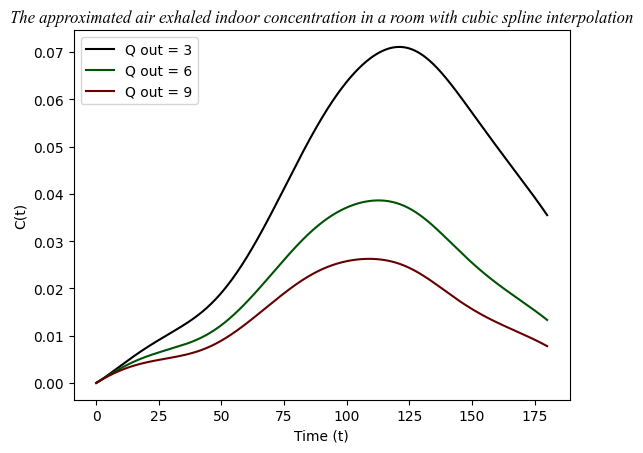

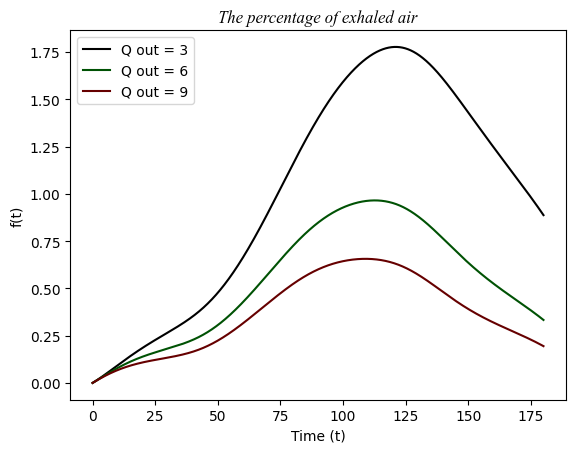

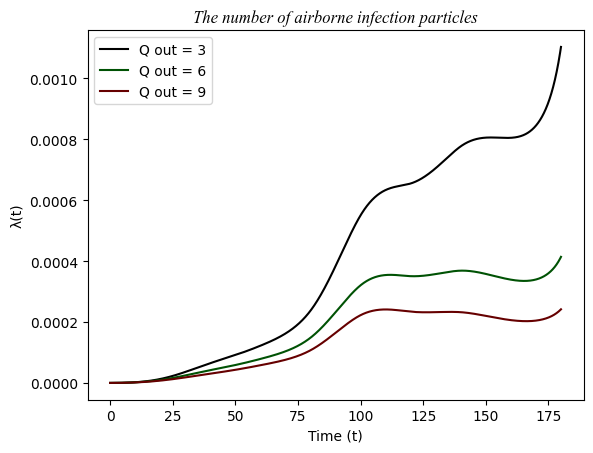

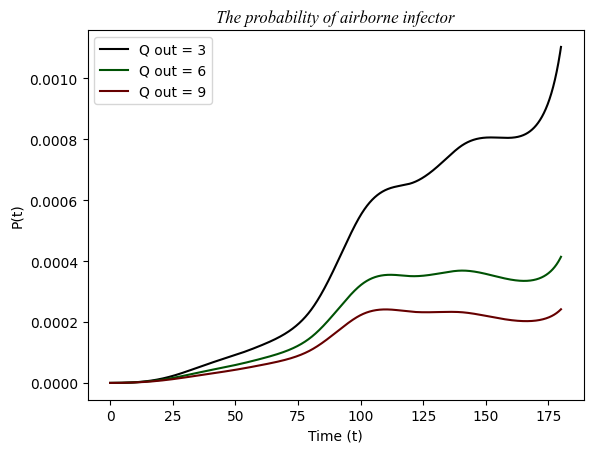

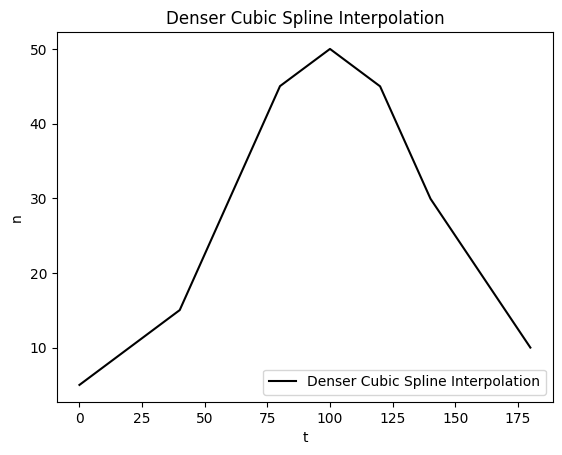

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# SIMULATION 5: The risk of normal peoples who staying in a room with infectors.
t_real = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180]
n_t_real = [5, 10, 15, 30, 45, 50, 45, 30, 20, 10]
I_t_real = [1, 3, 6, 8, 10, 15, 12, 9, 7, 6]

# Perform cubic spline interpolation based on real data
cs = CubicSpline(t_real, n_t_real)
cs_2 = CubicSpline(t_real, I_t_real)
cs_pts = cs.c


def model(t, C, p, Ca, Q, CE, V):
    dCdt = (1/V) * ((cs(t) * p * Ca) - (Q * C))
    return dCdt

# Define a function to calculate f(t) = C(t) / Ca
def calculate_f(C, Ca):
    return C / Ca

def calculate_N(C, B, m, p, Ca):
    return (cs_2(t)*C*(B-m))/cs(t)*p*Ca

def calculate_L(C, B, m, p, Ca, t, theta):
    return p*t*theta*calculate_N(C, B, m, p, Ca)

def calculate_P(C, B, m, p, Ca, t, theta):
    return 1 - np.exp(-calculate_L(C, B, m, p, Ca, t, theta))


def runge_kutta_adaptive(model, t, w, h, p, Ca, Q, CE, V):
    k1 = h * model(t, w, p, Ca, Q, CE, V)
    k2 = h * model(t + 1/4 * h, w + 1/4 * k1, p, Ca, Q, CE, V)
    k3 = h * model(t + 3/8 * h, w + 3/32 * k1 + 9/32 * k2, p, Ca, Q, CE, V)
    k4 = h * model(t + 12/13 * h, w + 1932/2197 * k1 - 7200/2197 * k2 + 7296/2197 * k3, p, Ca, Q, CE, V)
    k5 = h * model(t + h, w + 439/216 * k1 - 8 * k2 + 3680/513 * k3 - 845/4104 * k4, p, Ca, Q, CE, V)
    k6 = h * model(t + 1/2 * h, w - 8/27 * k1 + 2/27 * k2 - 3544/2565 * k3 + 1859/4104 * k4 - 11/40 * k5, p, Ca, Q, CE, V)

    w_new = w + 25/216 * k1 + 1408/2565 * k3 + 2197/4104 * k4 - 1/5 * k5

    return w_new


def adaptive_rk4_solver(model, C0, t, p, Ca, Q, CE, V, tol=1e-3):
    C_adaptive_rk4 = np.zeros_like(t)
    C_adaptive_rk4[0] = C0

    i = 0
    hmax = t[1] - t[0]
    hmin = 0.01
    flag = 1

    while flag == 1 and i < len(t) - 1:  # Adjust the loop condition here
        dt = t[i+1] - t[i]
        k1 = model(t[i], C_adaptive_rk4[i], p, Ca, Q, CE, V)
        k2 = model(t[i] + 0.5 * dt, C_adaptive_rk4[i] + 0.5 * dt * k1, p, Ca, Q, CE, V)
        k3 = model(t[i] + 0.5 * dt, C_adaptive_rk4[i] + 0.5 * dt * k2, p, Ca, Q, CE, V)
        k4 = model(t[i] + dt, C_adaptive_rk4[i] + dt * k3, p, Ca, Q, CE, V)

        # Estimate error
        error = np.abs((dt/6.0) * (k1 + 2*k2 + 2*k3 + k4))

        # Adjust the time step based on the error and tolerance
        delta = 0.84 * (tol / error)**0.25

        if delta <= 0.1:
            dt = 0.1 * dt
        elif delta >= 4:
            dt = 4 * dt
        else:
            dt = delta * dt

        if dt > hmax:
            dt = hmax

        if t[i] + dt > t[-1]:
            dt = t[-1] - t[i]
            flag = 0

        C_adaptive_rk4[i+1] = runge_kutta_adaptive(model, t[i], C_adaptive_rk4[i], dt, p, Ca, Q, CE, V)

        i += 1

    return C_adaptive_rk4[:i+1]  # Trim the result array to the actual size


# Define parameters
p = 0.12
Ca = 0.04
Q = [3, 6, 9]
CE = 0.01
V = 75
B = 1.5
m = 0.5
theta = 0.5
I = 10
labels = ["Q out = 3", "Q out = 6", "Q out = 9"]
colors = ['black', '#005204', '#660000']

# Define initial conditions
C0 = 0  # Initial concentration

# Define time points
t = np.arange(0, 180, 0.010)
f_adaptive_rk4 = []
L_adaptive_rk4 =  []
P_adaptive_rk4 = []

for i in range(len(Q)):
    # Solve the differential equation using Adaptive RK4 method
    C_adaptive_rk4 = adaptive_rk4_solver(model, C0, t, p, Ca, Q[i], CE, V)

    # Calculate f_adaptive_rk4 using the computed C_adaptive_rk4 and Ca
    f_adaptive= calculate_f(C_adaptive_rk4, Ca)
    f_adaptive_rk4.append(f_adaptive)


    L_adaptive = calculate_L(C_adaptive_rk4, B, m, p, Ca, t, theta)
    L_adaptive_rk4.append(L_adaptive)

    P_adaptive = calculate_P(C_adaptive_rk4, B, m, p, Ca, t, theta)
    P_adaptive_rk4.append(P_adaptive)

    # Generate more data points for a denser spline
    t_dense = np.linspace(0, 180, 7200)  # Create a denser set of time points
    n_dense = np.interp(t_dense, t_real, n_t_real)  # Interpolate values at denser time points

    # Perform cubic spline interpolation on the denser data
    cs_dense = CubicSpline(t_dense, n_dense)
    cs_dense_pts = cs_dense(t_dense)

    # Plot the solutions
    plt.plot(t, C_adaptive_rk4, label=labels[i], marker = '', linestyle='-', color = colors[i])
    

# Plot C_adaptive_rk4
plt.xlabel('Time (t)')
plt.ylabel('C(t)')
plt.title('The approximated air exhaled indoor concentration in a room with cubic spline interpolation', fontname='Times New Roman', fontstyle='italic')
plt.legend()
plt.show()

# Plot f_adaptive_rk4
for i in range(len(Q)):
    plt.plot(t, f_adaptive_rk4[i], label=labels[i], marker='', linestyle='-', color=colors[i])

plt.xlabel('Time (t)')
plt.ylabel('f(t)')
plt.title('The percentage of exhaled air', fontname='Times New Roman', fontstyle='italic')
plt.legend()
plt.show()

# Plot L_adaptive_rk4
for i in range(len(Q)):
    plt.plot(t, L_adaptive_rk4[i], label=labels[i], marker='', linestyle='-', color=colors[i])

plt.xlabel('Time (t)')
plt.ylabel('λ(t)')
plt.title('The number of airborne infection particles', fontname='Times New Roman', fontstyle='italic')
plt.legend()
plt.show()

# Plot L_adaptive_rk4
for i in range(len(Q)):
    plt.plot(t, P_adaptive_rk4[i], label=labels[i], marker='', linestyle='-', color=colors[i])

plt.xlabel('Time (t)')
plt.ylabel('P(t)')
plt.title('The probability of airborne infector', fontname='Times New Roman', fontstyle='italic')
plt.legend()
plt.show()


# Plotting cubic spline interpolation
plt.plot(t_dense, cs_dense_pts, label='Denser Cubic Spline Interpolation', linestyle='-', color="black")
plt.xlabel('t')
plt.ylabel('n')
plt.title('Denser Cubic Spline Interpolation')
plt.legend()
plt.show()





In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# SIMULATE 1: an ideal carbon dioxide concentration measurement.
t_real = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180]
n_t_real = [5, 10, 15, 30, 45, 50, 45, 30, 20, 10]

# Perform cubic spline interpolation on the analytical solution
cs = CubicSpline(t_real, n_t_real)
cs_pts = cs.c


def model(t, C, p, Ca, Q, CE, V):
    dCdt = (1/V) * ((cs(t) * p * Ca) - (Q * C))
    return dCdt

# Define a function to calculate f(t) = C(t) / Ca
def calculate_f(C, Ca):
    return C / Ca



def runge_kutta_adaptive(model, t, w, h, p, Ca, Q, CE, V):
    k1 = h * model(t, w, p, Ca, Q, CE, V)
    k2 = h * model(t + 1/4 * h, w + 1/4 * k1, p, Ca, Q, CE, V)
    k3 = h * model(t + 3/8 * h, w + 3/32 * k1 + 9/32 * k2, p, Ca, Q, CE, V)
    k4 = h * model(t + 12/13 * h, w + 1932/2197 * k1 - 7200/2197 * k2 + 7296/2197 * k3, p, Ca, Q, CE, V)
    k5 = h * model(t + h, w + 439/216 * k1 - 8 * k2 + 3680/513 * k3 - 845/4104 * k4, p, Ca, Q, CE, V)
    k6 = h * model(t + 1/2 * h, w - 8/27 * k1 + 2/27 * k2 - 3544/2565 * k3 + 1859/4104 * k4 - 11/40 * k5, p, Ca, Q, CE, V)

    w_new = w + 25/216 * k1 + 1408/2565 * k3 + 2197/4104 * k4 - 1/5 * k5

    return w_new


def adaptive_rk4_solver(model, C0, t, p, Ca, Q, CE, V, tol=1e-3):
    C_adaptive_rk4 = np.zeros_like(t)
    C_adaptive_rk4[0] = C0

    i = 0
    hmax = t[1] - t[0]
    hmin = 0.01
    flag = 1

    while flag == 1 and i < len(t) - 1:  # Adjust the loop condition here
        dt = t[i+1] - t[i]
        k1 = model(t[i], C_adaptive_rk4[i], p, Ca, Q, CE, V)
        k2 = model(t[i] + 0.5 * dt, C_adaptive_rk4[i] + 0.5 * dt * k1, p, Ca, Q, CE, V)
        k3 = model(t[i] + 0.5 * dt, C_adaptive_rk4[i] + 0.5 * dt * k2, p, Ca, Q, CE, V)
        k4 = model(t[i] + dt, C_adaptive_rk4[i] + dt * k3, p, Ca, Q, CE, V)

        # Estimate error
        error = np.abs((dt/6.0) * (k1 + 2*k2 + 2*k3 + k4))

        # Adjust the time step based on the error and tolerance
        delta = 0.84 * (tol / error)**0.25

        if delta <= 0.1:
            dt = 0.1 * dt
        elif delta >= 4:
            dt = 4 * dt
        else:
            dt = delta * dt

        if dt > hmax:
            dt = hmax

        if t[i] + dt > t[-1]:
            dt = t[-1] - t[i]
            flag = 0

        C_adaptive_rk4[i+1] = runge_kutta_adaptive(model, t[i], C_adaptive_rk4[i], dt, p, Ca, Q, CE, V)

        i += 1

    return C_adaptive_rk4[:i+1]  # Trim the result array to the actual size


# Define parameters
p = 0.12
Ca = 0.04
Q = [3, 6, 9]
CE = 0.01
V = 75
labels = ["Q out = 3", "Q out = 6", "Q out = 9"]
colors = ['black', '#005204', '#660000']

# Define initial conditions
C0 = 0  # Initial concentration

# Define time points
t = np.arange(0, 180, 0.010)

for i in range(len(Q)):
    # Solve the differential equation using Adaptive RK4 method
    C_adaptive_rk4 = adaptive_rk4_solver(model, C0, t, p, Ca, Q[i], CE, V)

    # Calculate f_adaptive_rk4 using the computed C_adaptive_rk4 and Ca
    f_adaptive_rk4 = calculate_f(C_adaptive_rk4, Ca)


    # Generate more data points for a denser spline
    t_dense = np.linspace(0, 180, 7200)  # Create a denser set of time points
    n_dense = np.interp(t_dense, t_real, n_t_real)  # Interpolate values at denser time points

    # Perform cubic spline interpolation on the denser data
    cs_dense = CubicSpline(t_dense, n_dense)
    cs_dense_pts = cs_dense(t_dense)

    # Plot the solutions
    
    


plt.xlabel('Time (t)')
plt.ylabel('C(t)')
plt.title('The approximated air exhaled indoor concentration in a room with cubic spline interpolation', fontname='Times New Roman', fontstyle='italic')
plt.legend()
plt.show()



plt.xlabel('Time (t)')
plt.ylabel('f(t)')
plt.title('The percentage of exhaled air')
plt.legend()
plt.show()


# Plotting the denser cubic spline interpolation
plt.plot(t_dense, cs_dense_pts, label='Denser Cubic Spline Interpolation', linestyle='-', color="black")
plt.xlabel('t')
plt.ylabel('n')
plt.title('Denser Cubic Spline Interpolation')
plt.legend()
plt.show()





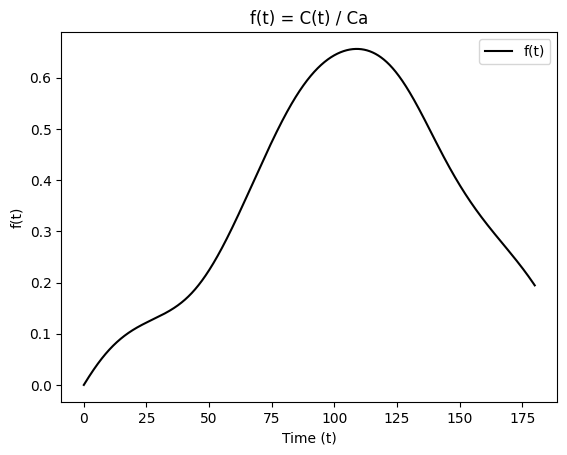

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

Ca = 0.04  # Your Ca value

# Define a function to calculate f(t) = C(t) / Ca
def calculate_f(C, Ca):
    return C / Ca

# Calculate f_adaptive_rk4 using the computed C_adaptive_rk4 and Ca
f_adaptive_rk4 = calculate_f(C_adaptive_rk4, Ca)

# Plotting f_adaptive_rk4 against time
t = np.arange(0, 180, 0.010)  # Assuming the time array used in C_adaptive_rk4 calculation

plt.plot(t, f_adaptive_rk4, label='f(t)', marker='', linestyle='-', color='black')
plt.xlabel('Time (t)')
plt.ylabel('f(t)')
plt.title('f(t) = C(t) / Ca')
plt.legend()
plt.show()
